# Inference plots - Autocorrelation plot

This example extends from the inference-adaptive-covariance-mcmc: https://github.com/pints-team/pints/blob/master/examples/inference-adaptive-covariance-mcmc.ipynb, and shows you different way to plot the results of an MCMC routine.

Inference plots
* [Trace plots](https://github.com/pints-team/pints/blob/master/examples/plot-mcmc-trace-plots.ipynb)
* [Pairwise scatterplots](https://github.com/pints-team/pints/blob/master/examples/plot-mcmc-pairwise-scatterplots.ipynb)
* __Autocorrelation plot__
* [Predicted time series](https://github.com/pints-team/pints/blob/master/examples/plot-mcmc-predicted-time-series.ipynb)


## Basic MCMC setup

The same setup used in the inference-adaptive-covariance-mcmc example.

In [1]:
from __future__ import print_function
import pints
import pints.toy as toy
import numpy as np
import matplotlib.pyplot as pl

# Load a forward model
model = toy.LogisticModel()

# Create some toy data
real_parameters = [0.015, 500]
times = np.linspace(0, 1000, 100)
org_values = model.simulate(real_parameters, times)

# Add noise
noise = 50
values = org_values + np.random.normal(0, noise, org_values.shape)
real_parameters = np.array(real_parameters + [noise])

# Get properties of the noise sample
noise_sample_mean = np.mean(values - org_values)
noise_sample_std = np.std(values - org_values)

# Create an object with links to the model and time series
problem = pints.SingleSeriesProblem(model, times, values)

# Create a log-likelihood function (adds an extra parameter!)
log_likelihood = pints.UnknownNoiseLogLikelihood(problem)

# Create a uniform prior over both the parameters and the new noise variable
prior = pints.UniformPrior(
    [0.01, 400, noise*0.1],
    [0.02, 600, noise*100]
    )

# Create a Bayesian log-likelihood (prior * likelihood)
log_likelihood = pints.BayesianLogLikelihood(prior, log_likelihood)

# Run an adaptive mcmc routine
x0 = real_parameters * 1.2
mcmc = pints.AdaptiveCovarianceMCMC(log_likelihood, x0)
mcmc.set_verbose(False)


## Autocorrelation plot

Autocorrelation is a number between negative 1 and positive 1 which measures how linearly dependent the current value of the chain is to past $\tau$ values called lags. See, e.g., https://en.wikipedia.org/wiki/Autocorrelation.

This allows us to diagnose the need for thinning and the number of iterations needed.


Running
Done!


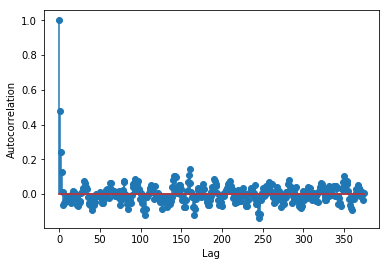

In [2]:
print('Running')
chain = mcmc.run()
print('Done!')

# Compute autocorrelation
def autocorrelation(x):
    xp = x - np.mean(x)
    f = np.fft.fft(xp)
    p = np.array([(np.real(v)**2 + np.imag(v)**2) for v in f])
    pi = np.fft.ifft(p)
    return np.real(pi)[:x.size/2]/np.sum(xp**2)

# Show autocorrelation plot
pl.figure()
ax = pl.subplot(111)
ax.stem(autocorrelation(chain[:,0]))
ax.set_xlabel('Lag')
ax.set_ylabel('Autocorrelation')
pl.show()